# LTA_9_Figures

In [1]:
from pathlib import Path
import importlib


import hydrofunctions as hf

import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import mpl_toolkits.axes_grid1.inset_locator as mpl_inset

#%matplotlib --list
#%matplotlib qt
#%matplotlib ipympl
%matplotlib inline

import seaborn as sns

import analysis_functions as my
importlib.reload(my)

my.markdown("## Import dependencies")

from scipy.stats import linregress, theilslopes
import statsmodels.api as sm

my.print_versions()

## Import dependencies

Package Versions
----------------
Python: 3.10.16
numpy: 1.26.4
pandas: 2.2.3
scipy: 1.15.1
statsmodels: 0.14.4
pangoin: not imported
matplotlib: 3.10.0
seaborn: 0.13.2
hydrofunctions: 0.2.4
analysis_funtions: 2025.06.27


In [2]:
my.markdown(f"## Figure settings")

# User settings
folder = "figures" # Put all figures into this folder; use None if you don't want a folder
filetype = "jpg"   # Output filetype
dpi = 600          # Output dpi

# Run this cell before running the ones that save a figure. It will create a directory if needed.
path = Path(folder)  # Works with Windows / Mac / Unix
path.mkdir(parents=True, exist_ok=True)  # create the directory and any parent directories if they don't exist

# combine path, filename, and extension using the / operator to combine:
# path / f'my_filename.{filetype}'


# filename = path / f'my_filename.{filetype}'
# print(f"Saving figure to {filename}")
# fig.savefig(filename, dpi=dpi, bbox_inches='tight')


## Figure settings

In [3]:
my.markdown(f"## Import Data")

# Station and reach data
stations = pd.read_parquet('stations.parquet') # location of stations on the WB Susquehanna
reaches = pd.read_parquet('reaches.parquet')  # Length of different reaches

# Load Field data collected by USGS staff
#field = pd.read_parquet('field_data.parquet')

# USGS Stream Gauge data
Q = pd.read_parquet('WBdata-discharge.parquet')
stage = pd.read_parquet('WBdata-stage.parquet')
depth = pd.read_parquet('WBdata-depth.parquet')

# Cross-Correlation results
xcorr = pd.read_parquet('xcorr_output.parquet')

# Validation data. Tables are organized: rows-wave; columns-site or reach.
val_celerity = pd.read_parquet('validation_celerity-table.parquet')
val_time = pd.read_parquet('validation_times-table.parquet')
val_depth = pd.read_parquet('validation_depths-table.parquet')
val_reaches = pd.read_parquet('validation_reaches.parquet')

## Import Data

In [4]:
my.markdown(f"## Download Field Data from USGS")

# Download field data for each station
field_tables = []
start = '2012-10-01'
stop = '2016-10-01'

for station in stations.index:
    field_obj = my.FieldMeas(station, start, stop, verbose=False)
    print(field_obj) #This will show the number of observations
    field_tables.append(field_obj.table)

# Concatenate with only dates as the index
field = pd.concat(field_tables)
# Subtract the StageQ0root from stage to get depths
field['depth_m'] = field.apply(lambda x: np.nan if pd.isnull(x.gage_height_va_m) else x.gage_height_va_m - stations.loc[x.site_no, 'StageQ0root'], axis=1) 

# `field` will only contain rows between the start & stop dates where the measured discharge matches the gauge discharge
#print(f"Field shape: {field.shape}")
#field

## Download Field Data from USGS

FieldMeas(site=01541200, start=2012-10-01, stop=2016-10-01, file=field_meas_01541200.rdb.gz, verbose=False)
    .table: 35 rows × 43 columns
    .historical_table: 600 rows × 42 columns
FieldMeas(site=01541303, start=2012-10-01, stop=2016-10-01, file=field_meas_01541303.rdb.gz, verbose=False)
    .table: 28 rows × 43 columns
    .historical_table: 354 rows × 42 columns
FieldMeas(site=01542500, start=2012-10-01, stop=2016-10-01, file=field_meas_01542500.rdb.gz, verbose=False)
    .table: 20 rows × 43 columns
    .historical_table: 612 rows × 42 columns
FieldMeas(site=01545500, start=2012-10-01, stop=2016-10-01, file=field_meas_01545500.rdb.gz, verbose=False)
    .table: 23 rows × 43 columns
    .historical_table: 764 rows × 42 columns
FieldMeas(site=01551500, start=2012-10-01, stop=2016-10-01, file=field_meas_01551500.rdb.gz, verbose=False)
    .table: 15 rows × 43 columns
    .historical_table: 781 rows × 42 columns


In [5]:
my.markdown(f"## Figure 1 Map")
# This figure was created outside Jupyter

## Figure 1 Map

# Figure 2 Rating Curve Curwensville

## Figure 2 Rating Curve Curwensville

Retrieved the rating curve for site #01541200 from https://waterdata.usgs.gov/nwisweb/data/ratings/exsa/USGS.01541200.exsa.rdbb
Saving figure to figures\Figure_02.jpg


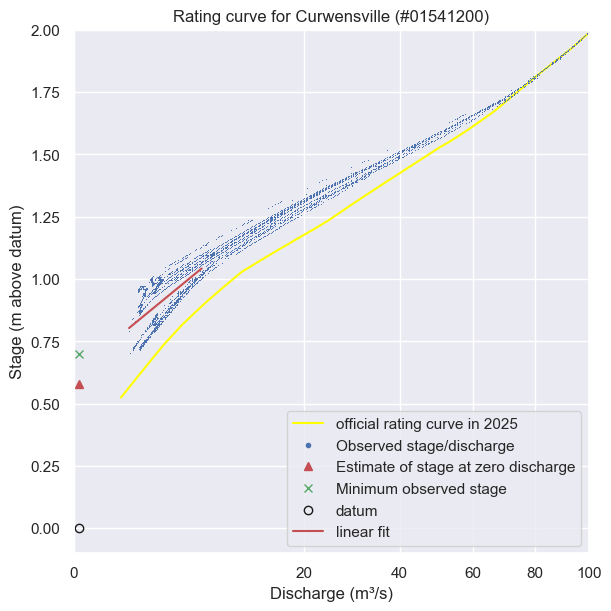

In [6]:
my.markdown(f"## Figure 2 Rating Curve Curwensville")
sns.set_theme(style="darkgrid")

def forward(a):
    return np.sqrt(a)

def inverse(a):
    return a**2
site = '01541200'

# Rating curve is in feet and cubic feet! Convert to metric
curve = hf.rating_curve(site).table
curve.loc[:,'discharge_cms'] = curve.loc[:,'discharge'] * 0.0283168
curve.loc[:,'stage_m'] = curve.loc[:,'stage'] * 0.3048

fig, ax = plt.subplots(figsize=(6, 6), layout='constrained')
ax.plot(curve.loc[:,'discharge_cms'], curve.loc[:,'stage_m'], color='yellow', label='official rating curve in 2025')
ax.plot(Q.loc[:,site], stage.loc[:,site], 'b,')#, label='Observed stage/discharge')
ax.plot([], 'b.', label='Observed stage/discharge')
#ax.plot(0.001, DF.loc[site,'StageQ0'], 'r+', label='model estimate of stage at zero discharge')
ax.plot(0.01, stations.loc[site,'StageQ0root'], 'r^', label='Estimate of stage at zero discharge')
ax.plot(0.01, stations.loc[site, 'StageMin'], 'gx', label='Minimum observed stage')
ax.plot(0.01,0, 'ko', fillstyle='none', label='datum')
# Values from LTA_1_Stations
x = [1.158157, 6.173062]
y = [0.803376, 1.042311]
ax.plot(x, y, 'r-', label=r'linear fit')#: stage = $\sqrt{discharge}$')
#ax.plot(X, y, '.')
ax.set_ylim([-0.1, 2])
ax.set_xlim([0, 100])
ax.set_xscale('function', functions=(forward, inverse))

#ax.margins(x=0.1)
ax.set_xlabel("Discharge (m³/s)")
ax.set_ylabel("Stage (m above datum)")
ax.set_title("Rating curve for " + stations.loc[site, 'name'] + " (#" + site + ")" )
ax.legend(loc="lower right")
sns.set_theme(style="darkgrid")

filename = path / f"Figure_02.{filetype}"
print(f"Saving figure to {filename}")
fig.savefig(filename, dpi=dpi, bbox_inches='tight')

# Figure 3 Filter Examples

## Figure 3 Filter Examples

Saving figure to figures\Figure_03.jpg


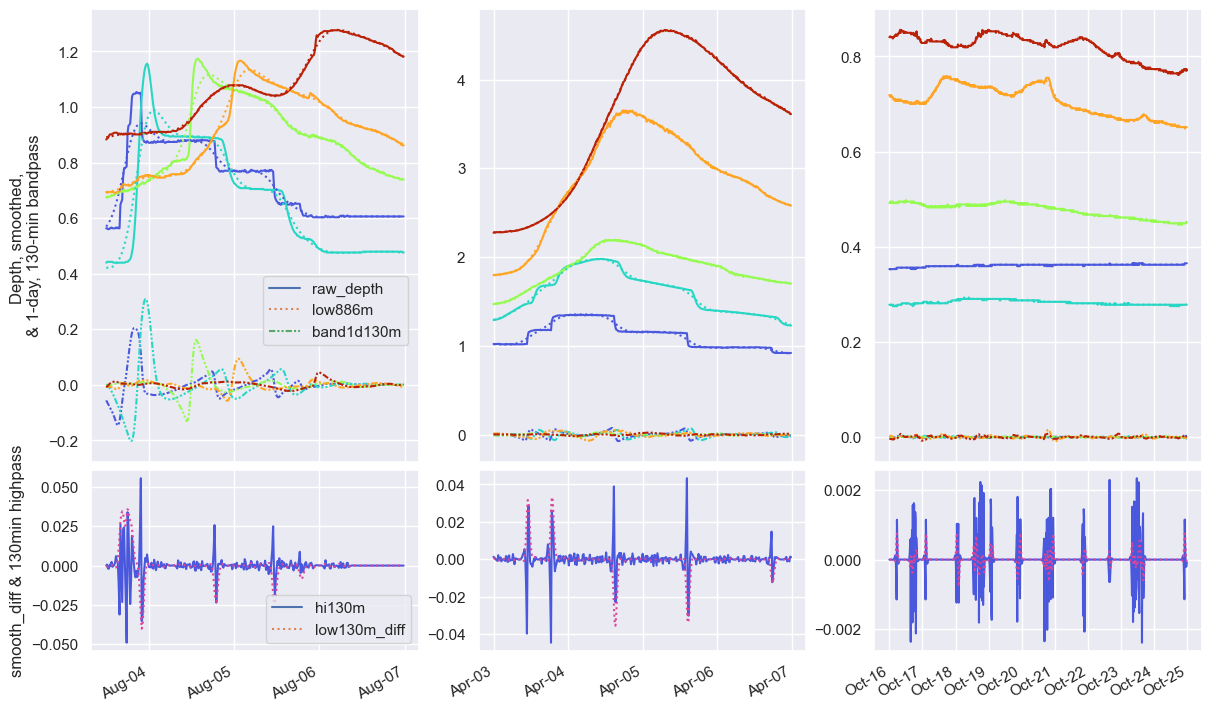

In [7]:
my.markdown(f"## Figure 3 Filter Examples")
# https://matplotlib.org/3.7.1/users/explain/figures.html
# Convert to single figure file

sns.set_theme(style="darkgrid")

depth = pd.read_parquet("WBdata-depth.parquet").interpolate()

filter_list = {'raw_depth': depth}
filter_list['hi130m'] = my.filter(depth, cutoff='130 minutes', sample_period='15 minutes', filter_type='highpass', filter_method='butterworth')
filter_list['low130m'] = my.filter(depth, cutoff='130 minutes', sample_period='15 minutes', filter_type='lowpass', filter_method='butterworth')
filter_list['low886m'] = my.filter(depth, cutoff='886 minutes', sample_period='15 minutes', filter_type='lowpass', filter_method='butterworth')
filter_list['low130m_diff'] = filter_list['low130m'].diff()
filter_list['band1d130m'] = my.filter(depth, cutoff=['1 day','130 minutes'], sample_period='15 minutes', filter_type='bandpass', filter_method='butterworth')

%matplotlib inline
# Plot three samples of transformed data so we can see what it looks like transformed

plot_list = ['hi130m', 'low130m_diff', 'raw_depth', 'low886m', 'band1d130m']
plot_row = []
filter_line_styles = ['solid', 'dotted', 'solid', 'dotted', (0, (3, 1, 1, 1, 1, 1))]

plot_filters =  {k: filter_list[k] for k in plot_list} # Create a new dict with just the filters I want to plot...
length = len(plot_filters)
threshold = pd.Timedelta('1 hour')

sample_windows = [('2014-08-03 12:00','2014-08-06'),
                  ('2015-04-03','2015-04-06'),
                  ('2015-10-16','2015-10-24'),
                 ]




#fig.suptitle('Filter Examples')
import matplotlib.cbook as cbook
import matplotlib.dates as mdates

fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(12, 7), height_ratios=[5, 2], layout='constrained')

# Stuff we need to set in every ax
for ax in axs.flatten(): 
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%d'))
    for label in ax.get_xticklabels(which='major'):
        label.set(rotation=30, horizontalalignment='right')

# Work with each filter tag as our outer loop
for indx, (tag, data) in enumerate(plot_filters.items()):
    linestyle = filter_line_styles[indx]
    if tag in ['low130m_diff', 'hi130m']:
        # Plot these two tags in second row with special instructions
        plot_stations = ['01541200'] # Only plot one station for clarity
        row = 1
    else:
        plot_stations = stations.index
        row = 0

    # Plot each filter three times: once for each sample window
    for col, (start, stop) in enumerate(sample_windows):
        #print(f"    {col}")
        # Hide the tick labels for the top row
        axs[0][col].set_xticklabels([]) 
        for station in plot_stations:
            if tag == 'low130m_diff':
                plot_color = '#dd4499'
                plot_alpha = 1
            elif tag == 'hi130m':
                plot_color = '#4a58dd'
                plot_alpha = 1  #.5
            else:
                plot_color = stations.loc[station, 'color']
                plot_alpha = 1
            plot_data = data.loc[start:stop, station]
            
            axs[row][col].plot(plot_data, color=plot_color, alpha=plot_alpha, linestyle=linestyle)
    # Create a legend entry for each filter
    axs[row][0].plot([], linestyle=linestyle, label=tag)

axs[0][0].set_ylabel(f"Depth, smoothed, \n& 1-day, 130-min bandpass")
axs[1][0].set_ylabel(f"smooth_diff & 130min highpass")
axs[0][0].legend(loc='lower right', bbox_to_anchor=(0.99, 0.24))
axs[1][0].legend(loc='lower right')



filename = path / f"Figure_03.{filetype}"
print(f"Saving figure to {filename}")
fig.savefig(filename, dpi=dpi, bbox_inches='tight')

# Figure 4 Cross-Correlation

## Figure 4 Cross-Correlation

Saving figure to figures\Figure_04.jpg


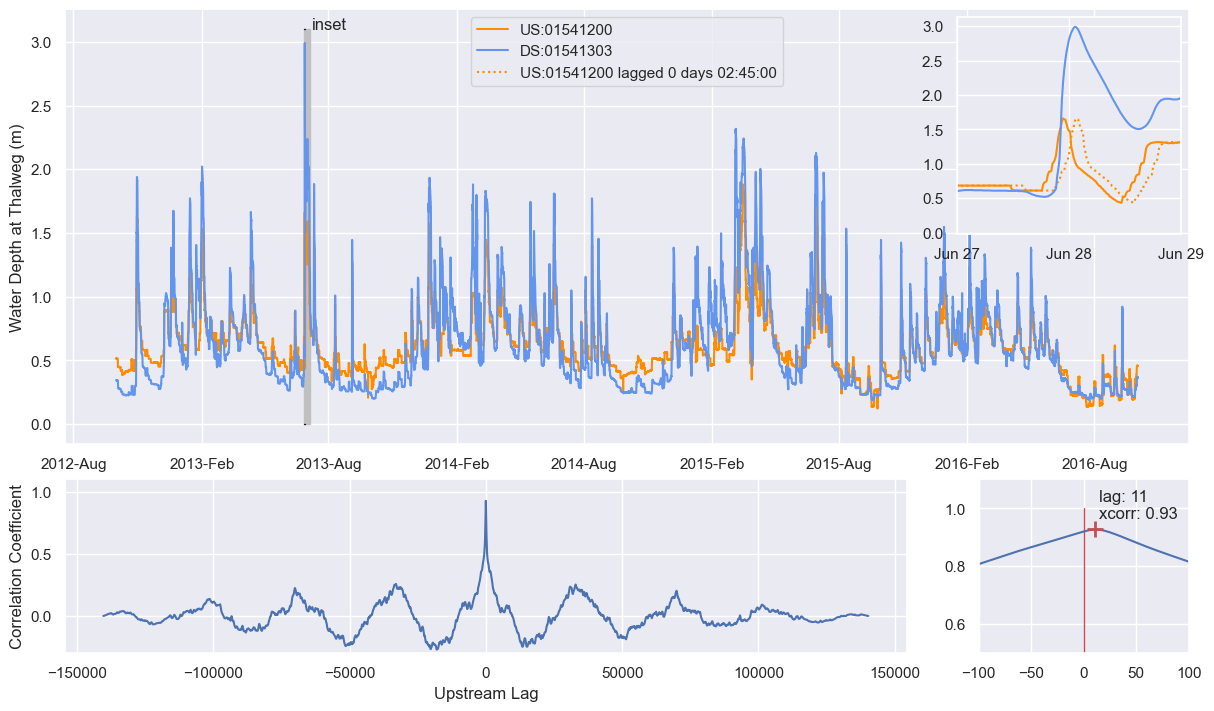

In [8]:
my.markdown(f"## Figure 4 Cross-Correlation")

US = '01541200'
DS = '01541303'

lags, ccor, ccov = my.xcorr_calc(depth[US], depth[DS])
stats = my.xcorr_stats(lags, ccor)
max_lag = stats['ccor_max_lag']
max_corr = stats['ccor_max']
interval = pd.Timedelta('15 minutes')
lag_time = max_lag * interval
# Inset time
start = pd.to_datetime('2013-06-27 00:00:00+00:00')
stop = pd.to_datetime('2013-06-29 00:00:00+00:00')
width = pd.Timedelta('9 days') #stop-start 

fig = plt.figure(layout='constrained',figsize=(12, 7))
axs = fig.subplot_mosaic("AA;BC", height_ratios=[5,2], width_ratios=[4,1])


#fig, (ax_top, ax_bot) = subplots(ncols=1, nrows=2, figsize=(12, 7), height_ratios=[5, 2], layout='constrained')
axs['A'].add_patch(plt.Rectangle((start, 0.0),  width, 3.1, fill=True, color='silver'))
axs['A'].plot(depth[US], color='darkorange', label=f'US:{US}')
axs['A'].plot(depth[DS], color='cornflowerblue', label=f'DS:{DS}')
axs['A'].plot([], color='darkorange', linestyle='dotted', label=f'US:{US} lagged {lag_time}') #add to legend
axs['A'].annotate("inset", xy=(start, 3.1), xytext=(6, 0), textcoords='offset points')
axs['A'].plot([start, stop], [0.0, 0.0], color='k', linestyle='-', linewidth=1)
axs['A'].plot([start, stop], [3.1, 3.1], color='k', linestyle='-', linewidth=1)
axs['A'].legend(loc="upper center")
axs['A'].set_ylabel("Water Depth at Thalweg (m)")
#for ax in axs.flatten(): 
axs['A'].xaxis.set_major_locator(mdates.MonthLocator(interval=6))
axs['A'].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))
#    for label in ax.get_xticklabels(which='major'):
#        label.set(rotation=30, horizontalalignment='right')

top_inset = mpl_inset.inset_axes(axs['A'], width="20%",height="50%",loc=1)
top_inset.plot(depth[US], color='darkorange', label=f'US:{US}')
top_inset.plot(depth[US].shift(max_lag), color='darkorange', linestyle='dotted', label=f'US:{US} lagged 2 hrs 45 min')
top_inset.plot(depth[DS], color='cornflowerblue', label=f'DS:{DS}')
top_inset.set_xlim(start, stop)
top_inset.xaxis.set_major_locator(mdates.DayLocator(interval=1))
top_inset.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

axs['B'] = my.xcorr_plot(lags, ccor, ax=axs['B'])
#axs['B'].axhline(0.6, ls=':')
axs['B'].set_xlabel("Upstream Lag")
axs['B'].set_ylabel("Correlation Coefficient")
axs['B'].set_ylim(-.3, 1.1)

axs['C'].plot([0, 0], [-1, 1], color='r', linestyle='-', linewidth=1)
axs['C'].plot(lags, ccor)
axs['C'].plot(max_lag, max_corr,'r+', markersize=12, markeredgewidth=2)
#axs['C'].axhline(0.6, ls=':')
annotation = f'lag: {max_lag} \nxcorr: {max_corr:.2f}'
axs['C'].annotate(annotation, xy=(max_lag, max_corr), xytext=(3, 8), textcoords='offset points')
axs['C'].set_xlim(-100, 100)
axs['C'].set_ylim(0.5, 1.1)
#mpl_inset.mark_inset(ax_bot, ax_bot_inset, 2, 4)



filename = path / f"Figure_04.{filetype}"
print(f"Saving figure to {filename}")
fig.savefig(filename, dpi=dpi, bbox_inches='tight')

# Figure 5 Reliability

In [9]:
xcorr.index.unique(level='method')

Index(['depth', 'depth-900', 'depth-dt', 'depth-dt-900', 'discharge',
       'discharge-900', 'discharge-dt', 'discharge-dt-900', 'band1d130m',
       'band1d130m-900', 'band1d130m-dt', 'band1d130m-dt-900', 'band3d130m',
       'band7d130m', 'band7d1d', 'band7d3d', 'smooth1daydiff', 'smooth130diff',
       'smooth130diff-900', 'smooth130diff-dt', 'smooth130m', 'smooth130m-dt',
       'smooth1d', 'band3d130m-900', 'band7d1d-900', 'band7d130m-900',
       'validation'],
      dtype='object', name='method')

# Figure 5 Reliability

Saving figure to figures\Figure_05.jpg


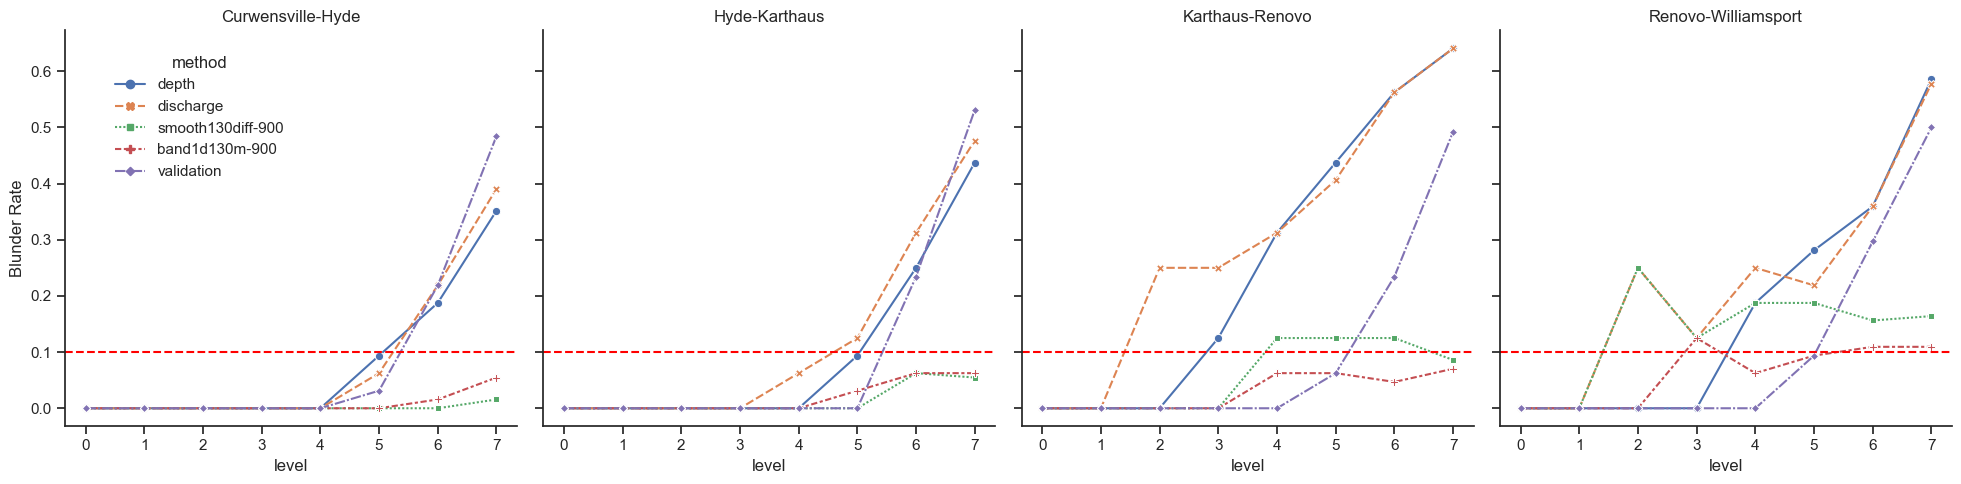

In [10]:
my.markdown(f"# Figure 5 Reliability")

sns.set_theme(style="ticks")

# Plot the table above for Criteria #1
# Which method has the lowest error rate?
# Consider each reach separately
# Find the highest possible level (shortest segment)
# If you calculate 'mean' on a boolean (like 'reasonable_c'), you get the % that are True.
methods = ['depth', 'discharge', 'smooth130diff-900', 'band1d130m-900', 'validation']
result = xcorr.loc[methods,'plausible_c'].ne(True).groupby(['method', 'reach', 'level'], sort=False).mean().reset_index()
# Offset to prevent overlap. or use jitter?)
#offset = [-0.02, -0.01, 0, 0.01, 0.02]
#grouped = result.groupby('method')
#grouped['level_o'] = grouped['level'].apply(lambda x: x + offset)

grid = sns.relplot(data=result, x='level', y='plausible_c', hue='method', style='method', col='reach', kind='line', markers=True)#, jitter=0.05)
grid.refline(y=0.1, color='red')
grid.set_ylabels("Blunder Rate")
grid.set_titles("{col_name}")
sns.move_legend(grid, "upper left", bbox_to_anchor=(.05, .9), frameon=False)


filename = path / f"Figure_05.{filetype}"
print(f"Saving figure to {filename}")
grid.savefig(filename, dpi=dpi, bbox_inches='tight')

In [11]:
def red_large(val):
    """
    Takes a scalar and returns a string with
    the css property `'color: red'` for negative
    strings, black otherwise.
    """
    color = 'red' if val > 0.1 else 'black'
    return 'color: %s' % color

#methods = ['validation','band1d130m', 'smooth130diff', 'depth', 'depth-dt']
result2 = xcorr.loc[:,'plausible_c'].ne(True).groupby(['method', 'level'], sort=False).mean()
result2.unstack().style.applymap(red_large)

C:\Users\marti\AppData\Local\Temp\ipykernel_17940\4080411785.py:12: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  result2.unstack().style.applymap(red_large)


level,0,1,2,3,4,5,6,7
method,,,,,,,,
depth,0.000000,0.000000,0.000000,0.031250,0.125000,0.226562,0.339844,0.503906
depth-900,0.000000,0.000000,0.000000,0.031250,0.125000,0.226562,0.339844,0.503906
depth-dt,0.000000,0.000000,0.000000,0.031250,0.109375,0.148438,0.328125,0.355469
depth-dt-900,0.000000,0.000000,0.000000,0.031250,0.109375,0.148438,0.324219,0.355469
discharge,0.000000,0.000000,0.125000,0.093750,0.156250,0.203125,0.363281,0.521484
discharge-900,0.000000,0.000000,0.125000,0.093750,0.156250,0.195312,0.355469,0.521484
discharge-dt,0.000000,0.000000,0.125000,0.093750,0.140625,0.171875,0.316406,0.380859
discharge-dt-900,0.000000,0.000000,0.125000,0.093750,0.140625,0.171875,0.304688,0.378906
band1d130m,0.000000,0.125000,0.062500,0.125000,0.109375,0.101562,0.082031,0.074219


# Figure 6 MAE robust

## Figure 6  Plausible Robust MAE

Saving figure to figures\Figure_06.jpg


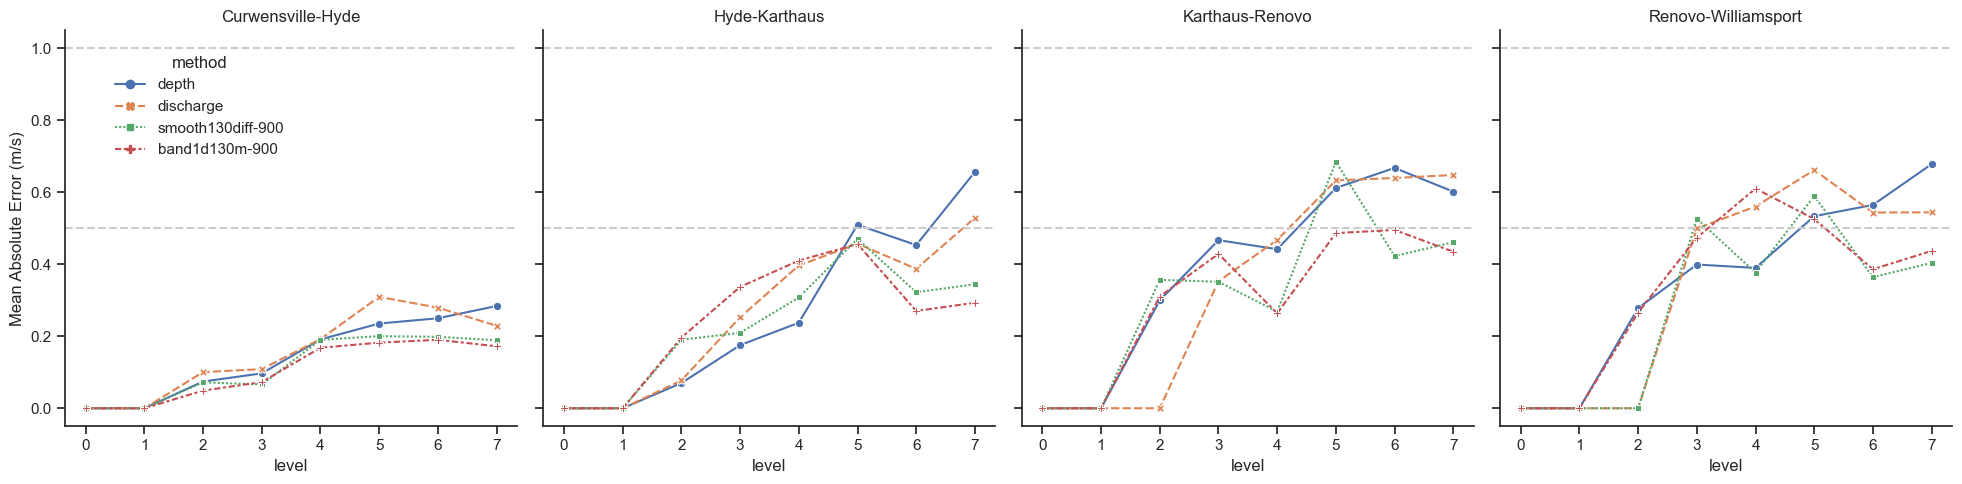

In [20]:
my.markdown(f"## Figure 6  Plausible Robust MAE")

sns.set_theme(style="ticks")

# Create a table for results
robust_df = pd.DataFrame()

no_mask = pd.Series(True, index=xcorr.index) # Keep everything
plausible_mask = xcorr['plausible_c'] # Filter out implausible values

def regress_vc(group):
    #print(group.name)
    method, level, reach = group.name

    clean_group = group.dropna()
    y = clean_group['avg_val_c']
    x = clean_group['celerity']
    if len(x) < 4:
        # If there are too few observations to run the stats, don't run them.
        robust_slope = 1.0
        robust_mae = 0.0
    else:
        #x = sm.add_constant(x)
        robust = sm.RLM(y, x).fit()
        robust_test = np.mean(np.abs(y - robust.fittedvalues))
        robust_slope = robust.params.iloc[0]
        robust_mae = np.mean(np.abs(robust.resid))
        #linear = linregress(x,y)
        #linear_fit = (linear.slope * x) + linear.intercept
        #resid = y - linear_fit
        #linear_mae = np.mean(np.abs(resid))
    
    return pd.Series([robust_slope, robust_mae, x.count()], index=['robust_slope', 'robust_mae', 'count'])

view_methods = ['depth', 'discharge', 'smooth130diff', 'band1d130m']
view_methods = ['depth', 'discharge', 'smooth130diff-900', 'band1d130m-900']
grouped = (xcorr.loc[plausible_mask]
            .loc[(view_methods),['avg_val_c', 'celerity']]
            .groupby(['method', 'level', 'reach'], sort=False)
          )
robust_df = grouped.apply(regress_vc)

grid = sns.relplot(
    data=robust_df, 
    x='level', 
    y='robust_mae', 
    hue='method', 
    style='method', 
    col='reach', 
    kind='line', 
    markers=True)
(grid.set_ylabels("Mean Absolute Error (m/s)")
     .set_titles("{col_name}")
     .tight_layout(w_pad=0)
     .refline(y=0.5, color="0.8")
     .refline(y=1, color="0.8")
)
sns.move_legend(grid, "upper left", bbox_to_anchor=(.05, .9), frameon=False)

#grid.savefig("Figure_6.png")
filename = path / f"Figure_06.{filetype}"
print(f"Saving figure to {filename}")
grid.savefig(filename, dpi=dpi, bbox_inches='tight')
#plt.close()

# Figure 7 Boxplots

## Figure 7 Boxplots

Saving figure to figures\Figure_07.jpg


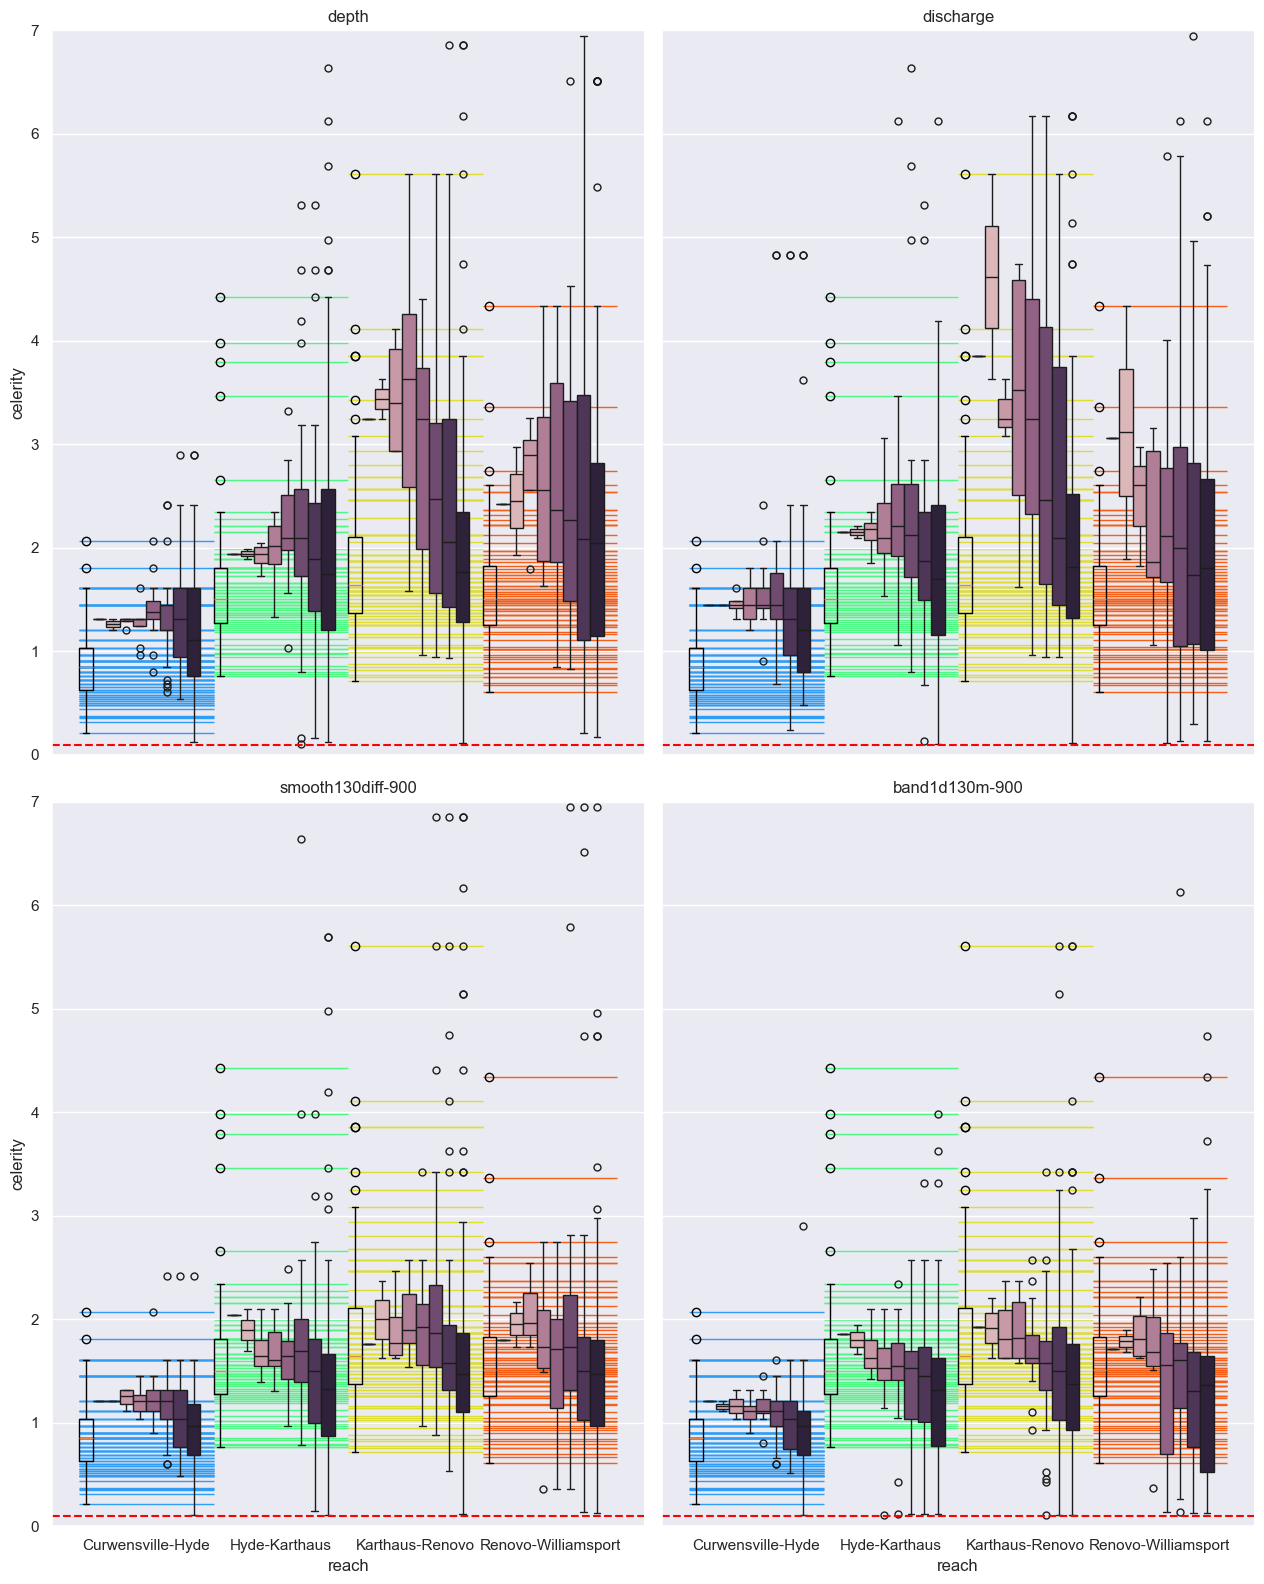

In [23]:
my.markdown(f"## Figure 7 Boxplots")
sns.set_theme(style="darkgrid")

%matplotlib inline
import matplotlib.ticker as ticker
# Subset the output table by choosing a method, level, reach, or one of the columns to display. Use a list to select more than one value.
methods = ['depth', 'discharge', 'smooth130diff-900', 'band1d130m-900']#, 'validation']
level = [0, 1, 2, 3, 4, 5, 6, 7]
reach = slice(None)
columns = 'celerity'
plaus_mask = xcorr.loc[:,'plausible_c']
selection = xcorr.loc[plaus_mask].loc[(methods, level, reach),:].reset_index()

# Add Validation Data
val_plot = val_reaches.set_index(['wave','reach'])['c'] # This creates a series of observed celerities. It has a multi-index with (wave#, reach). It doesn't contain any NaNs. There are ten waves; not every reach observed that wave.
val_plot.name = 'celerity'
# val_plot.loc[:,'Hyde-Karthaus']  # This will produce a series of celerity measurements for the reach 'Hyde-Karthaus'.

val_plot2 = val_plot.reset_index(level=1).reset_index()

# Description of "Boxen" or Letter-value Plot (Hoffman et al 2017):
# Hofmann, Heike; Wickham, Hadley; Kafadar, Karen. In: Journal of computational and graphical statistics. 26(3):469-477; Great Britain: AMERICAN STATISTICAL ASSOCIATION, 2017. 
# 
# plotted as Center box set at middle 50%, same as box plot
# Additional boxes are fourths, eigths, etc, IF 95% confidence interval does not include the range of the next box. This has the advantage of
# generally plotting less than 8 outliers, and providing more information about the tails of the distribution for large datasets.
# Median line

# Celerity limits set to [-2 to 15] meters / s
# red dotted line set at celerity = 0 m/s

grid = sns.catplot(x="reach", y="celerity", hue="level", data=selection, kind="box", col="method", col_wrap=2, height=8, aspect=.8, legend_out=False)
grid.set(ylim=(0, 7))
grid.refline(y=0.1, color='red')


def annotate(data, **kws):
    ax = plt.gca() #Get Current Axes
    # data has been flattened: it has a default index of row numbers.
    method = data.iloc[0,:]['method']
    reach = 'Curwensville-Hyde'
    reach_select = data.loc[:, 'reach'] == reach # This will select all rows with this reach
    pct_plausible = data.loc[reach_select,['level', 'plausible_c']].groupby(['level'])['plausible_c'].mean() #mean() will give %
    pct_list = list(pct_plausible.tolist())
    #print(f"pct_list: {pct_list}")
    #print_pct = [f'{x:.2 for x in pct_list}']
    #print(print_pct)
    
    my_text = f"{reach}\n% 'plausible' by level\n{pct_list}"
    boxdata = []
    position = [[-0.45], [0.55], [1.55], [2.55]]
    for i, reach in enumerate(reaches.index):
        color = reaches.loc[reach, 'color']
        xmin = i - 0.5
        xmax = i + 0.5
        ax.hlines(y=val_plot.loc[slice(None),reach], xmin=xmin, xmax=xmax, color=color, linewidth=1, zorder=0)
        x=val_plot.loc[:,reach].reset_index(drop=True).to_list()
        ax.boxplot(x=x, widths=0.1, positions=position[i], manage_ticks=False )#tick_labels=reach)
        #ax.xaxis.set_major_locator(ticker.NullLocator())
    #ax.boxplot(data=x)
grid.map_dataframe(annotate)
grid.set_titles("{col_name}")


#grid.savefig("Figure_7.png")
filename = path / f"Figure_07.{filetype}"
print(f"Saving figure to {filename}")
grid.savefig(filename, dpi=dpi, bbox_inches='tight')

#plt.close()

# Figure 8 depth c vs discharge c

## Figure 8 depth c vs discharge c

MAE: 0.2709136285586208
Mean difference x-y -0.03334474837931041
theil slope, intercept, min slope, max slope: TheilslopesResult(slope=0.8623234832746673, intercept=0.22698388541167747, low_slope=0.7399839608521693, high_slope=1.0)
Robust: <statsmodels.robust.robust_linear_model.RLMResultsWrapper object at 0x0000022AFE04DC30>
Least Squares: LinregressResult(slope=0.8415349499662036, intercept=0.38429897871418506, rvalue=0.9324937930933188, pvalue=1.8582573752540866e-13, stderr=0.06272999206541682, intercept_stderr=0.15452883998953487)
Least Square zero-intercept: 0.9817897057032074
Saving figure to figures\Figure_08.jpg


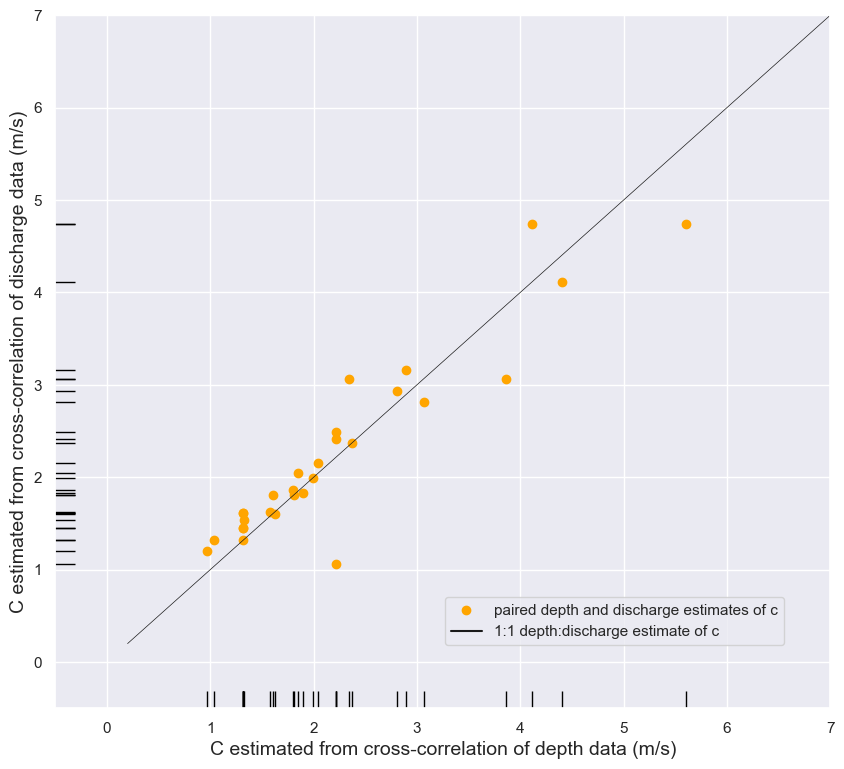

In [14]:
my.markdown(f"## Figure 8 depth c vs discharge c")

sns.set_theme(style="darkgrid")

%matplotlib inline
# Compare two estimates of celerity
method = ['depth', 'discharge']
level = 3
reach = slice(None)
columns = 'celerity'

# a mask for implausible values
plaus_mask = xcorr['plausible_c']
no_mask = pd.Series(True, index=xcorr.index)

selection = xcorr.loc[no_mask].loc[(method, level, reach),columns].unstack(level='method').dropna() #drop rows with NaN. unstacking can pair missing values with good values

x = selection.loc[:, method[0]] #depth
y = selection.loc[:, method[1]]
print(f"MAE: {np.mean(abs(x-y))}\nMean difference x-y {np.mean(x-y)}")

theil = theilslopes(y, x, 0.95)
print(f"theil slope, intercept, min slope, max slope: {theil}")


x2 = sm.add_constant(x)
robust = sm.RLM(y, x2).fit()
robust0 = sm.RLM(y, x).fit()
robust_mae = np.mean(np.abs(robust.resid))
print(f"Robust: {robust}")
linear = linregress(x,y)
linear_fit = (linear.slope * x) + linear.intercept
resid = y - linear_fit
linear_mae = np.mean(np.abs(resid))
print(f"Least Squares: {linear}")
slope0 = (x * y).sum() / (x * x).sum()
print(f"Least Square zero-intercept: {slope0}")



fig, ax = plt.subplots(figsize=(10,9))

line = matplotlib.lines.Line2D([0.2, 10], [0.2, 10], lw=0.5, c='k', axes=ax)
ax.add_line(line)
lsq_x = [x.min(), x.max()]
lsq_y = [((x * linear.slope) + linear.intercept) for x in lsq_x]

#ax.plot(lsq_x, lsq_y, 'k:', lw=0.5, label="least squares fit")
#ax.plot(x, robust.fittedvalues, 'k-', lw=0.5, label="robust fit")

#ax.plot(x, robust0.fittedvalues, 'g-', lw=0.5, label="robust fit, no intercept") # This is the best model of the relationship

#lsq0_y = [(x * slope0) for x in lsq_x]
#ax.plot(lsq_x, lsq0_y, 'g:', lw=0.5, label='least square, zero intercept')
ax.scatter(x=x, y=y, c='orange', label = f'paired depth and discharge estimates of c')
ax.plot([], 'k-', label='1:1 depth:discharge estimate of c')

#v_plot = validation.rename(columns={'level_1':'reach','c':'celerity'})
#ax.scatter(x=v_plot.loc[:,'celerity'], y=v_plot.loc[:,'celerity'], marker='x', linewidths=2, c='k', label='validation measurements')

sns.rugplot(x=x, c='black')
sns.rugplot(y=y, c='black')

ax.legend(loc="lower right", bbox_to_anchor=(0.95, 0.08))
ax.set_xlabel("C estimated from cross-correlation of depth data (m/s)", fontsize=14)
ax.set_ylabel("C estimated from cross-correlation of discharge data (m/s)", fontsize=14)
ax.set(ylim=(-0.5, 7))
ax.set(xlim=(-0.5, 7))

#fig.savefig('Figure_8.png')
filename = path / f"Figure_08.{filetype}"
print(f"Saving figure to {filename}")
fig.savefig(filename, dpi=dpi, bbox_inches='tight')
#plt.close()

# Figure 9 Cumulative c

## Figure 9 Cumulative c

Median Celerity by reach
Curwensville-Hyde      0.851895
Hyde-Karthaus          1.503145
Karthaus-Renovo        1.645448
Renovo-Williamsport    1.510016
Name: (c, 50%), dtype: object
Saving figure to figures\Figure_09.jpg


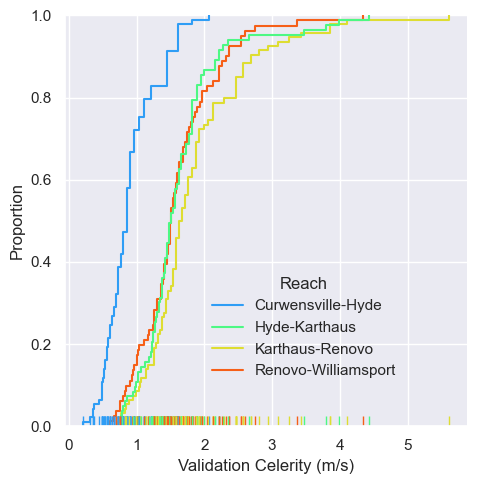

In [15]:
my.markdown(f"## Figure 9 Cumulative c")

sns.set_theme(style="darkgrid")

# Waves are slower in Curwensville-Hyde, slightly faster in Kart-Renovo
print(f"Median Celerity by", val_reaches.groupby('reach').describe().T.loc[('c', '50%')])
g = sns.displot(data=val_reaches, hue="reach", x="c", kind="ecdf", rug=True, palette=reaches.color.to_list())
g.set_axis_labels("Validation Celerity (m/s)")
sns.move_legend(g, "lower right", bbox_to_anchor=(.6, .2), title='Reach')

#g.savefig('Figure_9.png')
filename = path / f"Figure_09.{filetype}"
print(f"Saving figure to {filename}")
g.savefig(filename, dpi=dpi, bbox_inches='tight')
#plt.close()

# Figure 10 c:depth

## Figure 10 c:depth

C:\Users\marti\AppData\Local\Temp\ipykernel_17940\567680348.py:71: PerformanceWarning: indexing past lexsort depth may impact performance.
  plot_results = xcorr.loc[(method, 6),:]


Curwensville-Hyde: Validation data ⇒ r²: 0.53 p: 0.00 slope: 0.66 intercept: 0.21
Curwensville-Hyde: Cross-Correlation data ⇒ r²: 0.44 p: 0.00 slope: 0.80 intercept: 0.50
Curwensville-Hyde: Field Velocity data ⇒ r²: 0.71 p: 0.00 slope: 0.61 intercept: 0.31
Hyde-Karthaus: Validation data ⇒ r²: 0.30 p: 0.00 slope: 0.81 intercept: 0.57
Hyde-Karthaus: Cross-Correlation data ⇒ r²: 0.13 p: 0.01 slope: 0.70 intercept: 0.88
Hyde-Karthaus: Field Velocity data ⇒ r²: 0.91 p: 0.00 slope: 0.64 intercept: 0.22
Karthaus-Renovo: Validation data ⇒ r²: 0.51 p: 0.00 slope: 0.99 intercept: 0.30
Karthaus-Renovo: Cross-Correlation data ⇒ r²: 0.07 p: 0.04 slope: 0.66 intercept: 0.96
Karthaus-Renovo: Field Velocity data ⇒ r²: 0.89 p: 0.00 slope: 0.49 intercept: 0.06
Renovo-Williamsport: Validation data ⇒ r²: 0.26 p: 0.00 slope: 0.35 intercept: 0.89
Renovo-Williamsport: Cross-Correlation data ⇒ r²: 0.16 p: 0.00 slope: 0.53 intercept: 0.54
Renovo-Williamsport: Field Velocity data ⇒ r²: 0.61 p: 0.00 slope: 0.16 

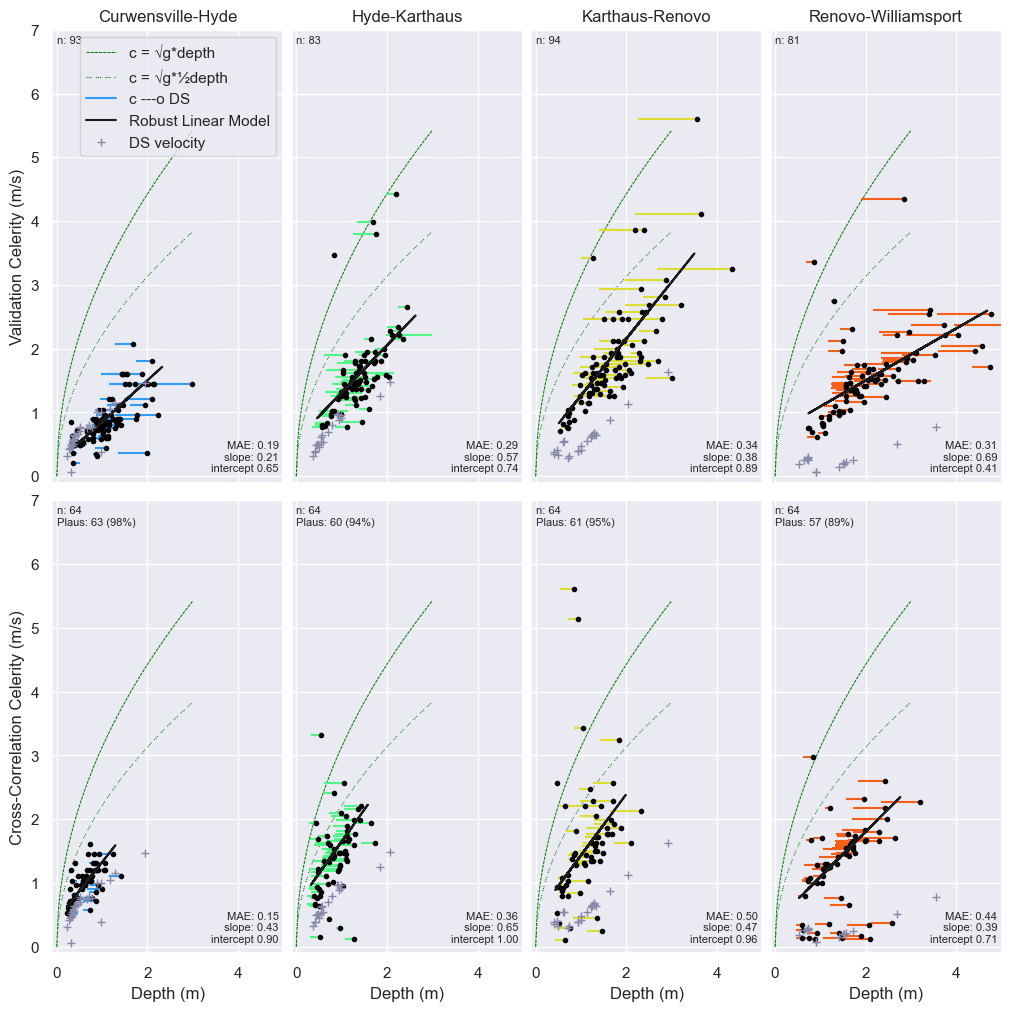

In [24]:
my.markdown(f"## Figure 10 c:depth")

sns.set_theme(style="darkgrid")

def add_gd(ax, xmin=0, xmax=3):
    #3: c = √g*D for a Theoretical curve
    x_range_m = np.linspace(xmin, xmax, 100) # A set of 100 points ranging from min to max
    y3 = (x_range_m * 9.8)**0.5
    y3b = (x_range_m * 0.5 * 9.8)**0.5
    ax.plot(x_range_m, y3, linestyle=(0,(3,1)), linewidth=0.75, color='green', label='c = √g*depth')
    ax.plot(x_range_m, y3b, linestyle=(0,(1,1,1,1,1,4)), linewidth=0.75, color='green', label='c = √g*½depth')
    return None

def plot_cd(ax, us_d, ds_d, c, color):
    # Plot horizontal lines representing the US depth to the DS depth at a celerity
    ax.hlines(c, us_d, ds_d, color=color)
    #ax.plot(us_d, c, 'x', color=color)
    ax.plot(ds_d, c, '.', color='black') #Plot point last to highlight DS depth
    #ax.plot(x5_avg, y5, 'o', color=reach_color)
    
    ax.plot([],[], linestyle='solid', color=color, label='c ---o DS')
    return None

def add_regress(x, y, ax=None, prt=True, source='', reach=''):
    # x & y are matching vectors
    # ax is the axis to draw to
    # prt is whether you should print the results
    # source is text for a label string that only gets used in printing.
    # reach is text for the print label string
    # returns the annotation text
    
    #print(x, y, ax, prt, source, reach)
    x_nulls = x.isnull().values.sum()
    y_nulls = y.isnull().values.sum()
    if (x_nulls > 0 | y_nulls > 0):
        print('Warning! nans present. x_nulls:{x_nulls}  y_nulls:{y_nulls} source:{source} reach:{reach}')
        return None
    exog = sm.add_constant(x) 
    robust = sm.RLM(y, exog).fit()
    robust_mae = np.mean(np.abs(robust.resid))
    #print(f"{reach} Robust: {robust}")
    #print(robust.summary())
    
    gradient, intercept, r_value, p_value, std_err = linregress(x, y)
    label_text = f'{source} data ⇒ r²: {r_value**2:.2f} p: {p_value:.2f} slope: {gradient:.2f} intercept: {intercept:.2f}'
    if prt:
        print(f"{reach}: {label_text}")
    if ax:
        # Plot XCorr regression line
        lo = (x.min())*0.7
        hi = (x.max())*1.3
        #ax.plot([lo, hi], [(gradient*lo)+intercept, (gradient*hi)+intercept], '-', color='black', linewidth=1, label='LS fit')
        ax.plot(x, robust.fittedvalues, "k-", label="Robust Linear Model")
        #ax.plot([lo, hi], [(robust.gradient*lo)+robust.intercept, (robust.gradient*hi)+robust.intercept], ':', color='green', linewidth=1, label='robust LS fit')
    #anno_text = f'r²: {r_value**2:.2f}\np: {p_value:.2f}\nslope: {gradient:.2f}\nintercept: {intercept:.2f}'
    slope = robust.params.iloc[0]
    intercept = robust.params.iloc[1]
    #print(f"Slope: {slope}, intercept {intercept}")
    anno_text = f"MAE: {robust_mae:.2f}\n slope: {slope:.2f}\nintercept {intercept:.2f}"
    #ax.annotate(anno_text, xytext=(0.01, 0.01), textcoords='axes fraction')
    return anno_text

def add_field_v(ax, field_table, symbol='g+'):
    x = field_table.loc['depth_m']
    y = field_table.loc['chan_velocity_ms']
    return ax.plot(x, y, symbol, label='Field-measured velocity')
    

method = 'band1d130m-900'

plot_results = xcorr.loc[(method, 6),:]

p5 = True    # plot validation data
p5fit = True # fit a regression line
p6 = True    # plot cross-correlation data
p6fit = True # fit a regression line
field_v = True # plot field-measured velocity data

fig, axes = plt.subplots(2, 4, figsize=(10, 10), sharey=True, sharex=True, layout='constrained')

for i, reach in enumerate(reaches.index.to_list()):
    # Add theoretical curve to every drawing
    add_gd(axes[1][i])
    add_gd(axes[0][i])
    
    reach_color = reaches.loc[reach, 'color']
    reach_marker = reaches.loc[reach, 'symbol']
    US = reaches.loc[reach, 'us']
    DS = reaches.loc[reach, 'ds']

    #5: c measured from validation waves
    if p5:
        val = val_reaches.loc[val_reaches['reach'] == reach]
        plot_cd(axes[0][i], val['USdepth'], val['DSdepth'], val['c'], reach_color)
        val_n_text = f"n: {len(val)}"
        axes[0][i].annotate(val_n_text, xy=(1,1), xytext=(0.02, 0.988), 
                            textcoords='axes fraction', va='top', ha='left',
                            fontsize=8)
        
    if p5fit:
        val.dropna(subset=['USdepth','DSdepth','c'])
        x = (val['USdepth'] + val['DSdepth'])/2
        r_text = add_regress(x, val['c'], axes[0][i], True, 'Validation', reach)
        axes[0][i].annotate(r_text, xy=(1,1), xytext=(0.98, 0.02),
                            textcoords='axes fraction', va='bottom', ha='right',
                            fontsize=8,
                            )

    #6: c measured from cross-correlation
    #data = plot_results.loc[reach, :].dropna(subset=['raw_us_data_mean','raw_ds_data_mean','celerity'])
    reach_data = plot_results.loc[reach, :]
    #na_mask = reach_data['celerity'].notna()
    plaus_mask = reach_data['plausible_c']
    inlier_mask = reach_data['inlier']
    data = reach_data.loc[plaus_mask] #only select inliers
    n = len(reach_data)
    n_plaus = plaus_mask.sum()
    n_inlier = inlier_mask.sum()
    
    if p6:
        plot_cd(axes[1][i], data['raw_us_data_mean'], data['raw_ds_data_mean'], data['celerity'], reach_color)
        n_text = f"n: {n} \nPlaus: {n_plaus} ({(n_plaus/n):.0%})"#\nCleaned: {n_inlier} ({(n_inlier/n):.0%})"
        axes[1][i].annotate(n_text, xy=(1,1), xytext=(0.02, 0.988), 
                            textcoords='axes fraction', va='top', ha='left',
                            fontsize=8)
    
    if p6fit:
        x = (data['raw_us_data_mean'] + data['raw_ds_data_mean'])/2
        r_text = add_regress(x, data['celerity'], axes[1][i], True, 'Cross-Correlation', reach)
        #axes[1][i].annotate(r_text, xytext=(0.01, 0.01), textcoords='axes fraction',
        #    va='top', ha='left',)
        
        axes[1][i].annotate(r_text, xy=(1,1), xytext=(0.98, 0.02),
                            textcoords='axes fraction', va='bottom', ha='right',
                            fontsize=8,
                            )
        
    if field_v:
        x = field.loc[field['site_no']==DS, 'depth_m']
        y = field.loc[field['site_no']==DS, 'chan_velocity_ms']
        axes[0][i].plot(x, y, '+', color='#88a', label='DS velocity')
        axes[1][i].plot(x, y, '+', color='#88a')
        field_text = add_regress(x, y, None, True, 'Field Velocity', reach)
    axes[0][0].legend(loc='upper right')
    #axes[i].set_xlim([0, x_max+x_max*0.10])
    #axes[i].set_ylim([0, y_max+y_max*0.15])
    #axes[i].set_ylim([0, 7])
    axes[1][i].set_xlabel("Depth (m)")
    axes[0][i].set_title(f'{reach}')
axes[0][0].set_ylabel("Validation Celerity (m/s)")
axes[1][0].set_ylabel("Cross-Correlation Celerity (m/s)")
axes[0][0].set(ylim=(-0.1, 7))
axes[0][0].set(xlim=(-0.1, 5))

#fig.savefig("Figure_10.png")
filename = path / f"Figure_10.{filetype}"
print(f"Saving figure to {filename}")
fig.savefig(filename, dpi=dpi, bbox_inches='tight')
#plt.close()

# Scratch Work Below here

## Plot xcorr c vs agg validation c

MAE: 0.39452989484089074
Mean difference x-y 0.08835623448785423
theil slope, intercept, min slope, max slope: TheilslopesResult(slope=0.8670399805541716, intercept=0.18699638913290184, low_slope=0.7580919850596815, high_slope=0.9761543247782085)
Robust slope, no intercept: 0.9110830213152314
Least Squares slope: 0.4397843448376463, intercept: 0.7614529464188209
Least Square zero-intercept slope: 0.8180083684110304


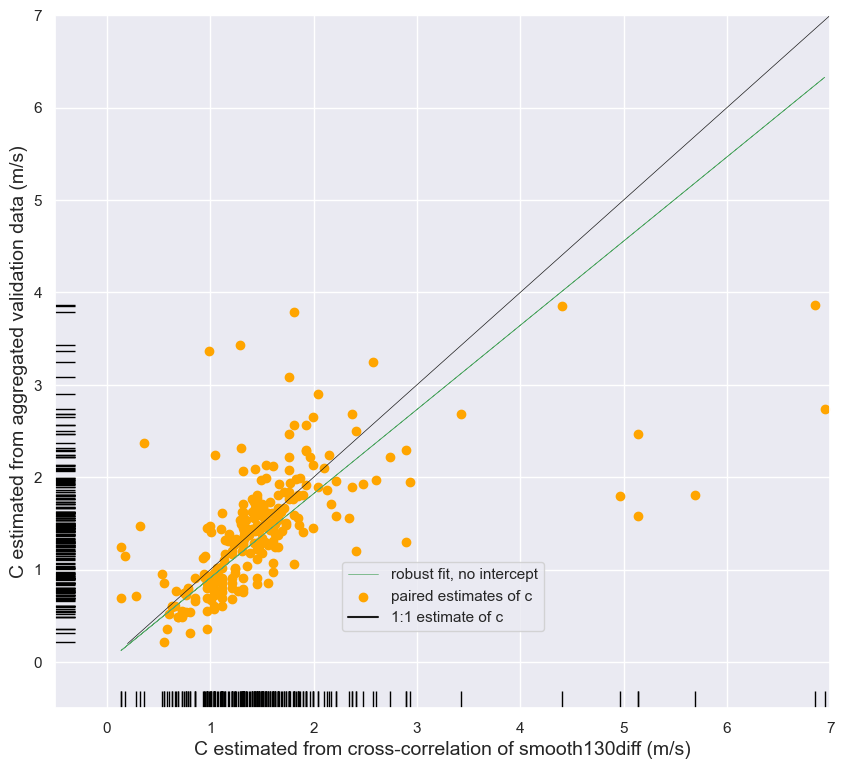

In [17]:
my.markdown(f"## Plot xcorr c vs agg validation c")

sns.set_theme(style="darkgrid")

%matplotlib inline
# Compare two estimates of celerity
#method = ['depth-1_900', 'discharge-1_900']
method = ['band1d130m', 'validation']
method = ['smooth130diff', 'validation']
#method = ['depth-1_900', 'validation']
level = 7
reach = slice(None)
columns = 'celerity'

# a mask for implausible values
plaus_mask = xcorr['plausible_c']
no_mask = pd.Series(True, index=xcorr.index)

selection = xcorr.loc[plaus_mask].loc[(method, level, reach),columns].unstack(level='method').dropna() #drop rows with NaN in pairs. unstacking can pair missing values with good values

x = selection.loc[:, method[0]]
y = selection.loc[:, method[1]]
print(f"MAE: {np.mean(abs(x-y))}\nMean difference x-y {np.mean(x-y)}")

theil = theilslopes(y, x, 0.95)
print(f"theil slope, intercept, min slope, max slope: {theil}")


#x2 = sm.add_constant(x)
#robust = sm.RLM(y, x2).fit()
robust = sm.RLM(y, x).fit()
robust_test = np.mean(np.abs(y - robust.fittedvalues))
robust_mae = np.mean(np.abs(robust.resid))
print(f"Robust slope, no intercept: {robust.params.iloc[0]}")
linear = linregress(x,y)
linear_fit = (linear.slope * x) + linear.intercept
resid = y - linear_fit
linear_mae = np.mean(np.abs(resid))
print(f"Least Squares slope: {linear.slope}, intercept: {linear.intercept}")
slope0 = (x * y).sum() / (x * x).sum()
print(f"Least Square zero-intercept slope: {slope0}")



fig, ax = plt.subplots(figsize=(10,9))

line = matplotlib.lines.Line2D([0.2, 10], [0.2, 10], lw=0.5, c='k', axes=ax)
ax.add_line(line)
lsq_x = [x.min(), x.max()]
lsq_y = [((x * linear.slope) + linear.intercept) for x in lsq_x]

#ax.plot(lsq_x, lsq_y, 'k:', lw=0.5, label="least squares fit")
#ax.plot(x, robust.fittedvalues, 'k-', lw=0.5, label="robust fit")

ax.plot(x, robust.fittedvalues, 'g-', lw=0.5, label="robust fit, no intercept") # This is the best model of the relationship

#lsq0_y = [(x * slope0) for x in lsq_x]
#ax.plot(lsq_x, lsq0_y, 'g:', lw=0.5, label='least square, zero intercept')
ax.scatter(x=x, y=y, c='orange', label = f'paired estimates of c')
ax.plot([], 'k-', label='1:1 estimate of c')

#v_plot = validation.rename(columns={'level_1':'reach','c':'celerity'})
#ax.scatter(x=v_plot.loc[:,'celerity'], y=v_plot.loc[:,'celerity'], marker='x', linewidths=2, c='k', label='validation measurements')

sns.rugplot(x=x, c='black')
sns.rugplot(y=y, c='black')

ax.legend(loc="lower center", bbox_to_anchor=(0.5, 0.10))
ax.set_xlabel(f"C estimated from cross-correlation of {method[0]} (m/s)", fontsize=14)
ax.set_ylabel("C estimated from aggregated validation data (m/s)", fontsize=14)
ax.set(ylim=(-0.5, 7))
ax.set(xlim=(-0.5, 7))


filename = path / f"Plot_xcorr_valid_c.{filetype}"
#print(f"Saving figure to {filename}")
#fig.savefig(filename, dpi=dpi, bbox_inches='tight')

## Old Figure 6 MAE Direct

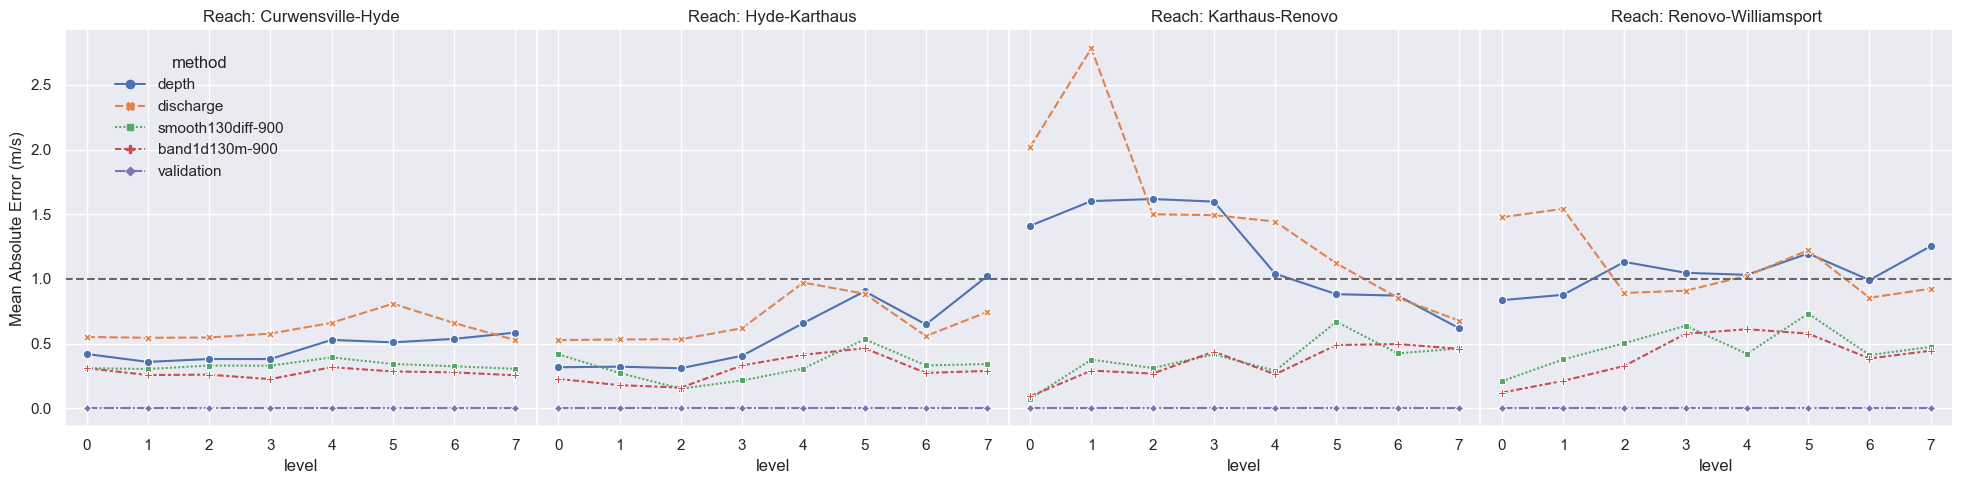

In [25]:
my.markdown(f"## Old Figure 6 MAE Direct")

# Plot Mean Absolute Difference by Method, Level, & Reach, Filtered
# Compare Xcorr c directly to validation c:  diff = validation_c - xcorr_c

view_methods = ['depth', 'discharge', 'smooth130diff-900', 'band1d130m-900', 'validation']
plot_data = (xcorr.loc[xcorr['plausible_c']] # Filter out unreasonable answers
                   .loc[(view_methods),'resid_c']
                   .dropna()
                   .groupby(['method', 'reach', 'level'], sort=False)
                   .agg(lambda x: np.mean(abs(x)))
            ).reset_index()
grid = sns.relplot(
    data=plot_data, 
    x='level', 
    y='resid_c', 
    hue='method', 
    style='method', 
    col='reach', 
    kind='line', 
    markers=True)
(grid.refline(y=1, color="0.4")
     .set_ylabels("Mean Absolute Error (m/s)")
     .set_titles("Reach: {col_name}")
     .tight_layout(w_pad=0)
)
sns.move_legend(grid, "upper left", bbox_to_anchor=(.05, .9), frameon=False)

filename = path / f"Old_Figure_6_Direct.{filetype}"
#print(f"Saving figure to {filename}")
#grid.savefig(filename, dpi=dpi, bbox_inches='tight')

## Old Figure 6 Using Least Squares

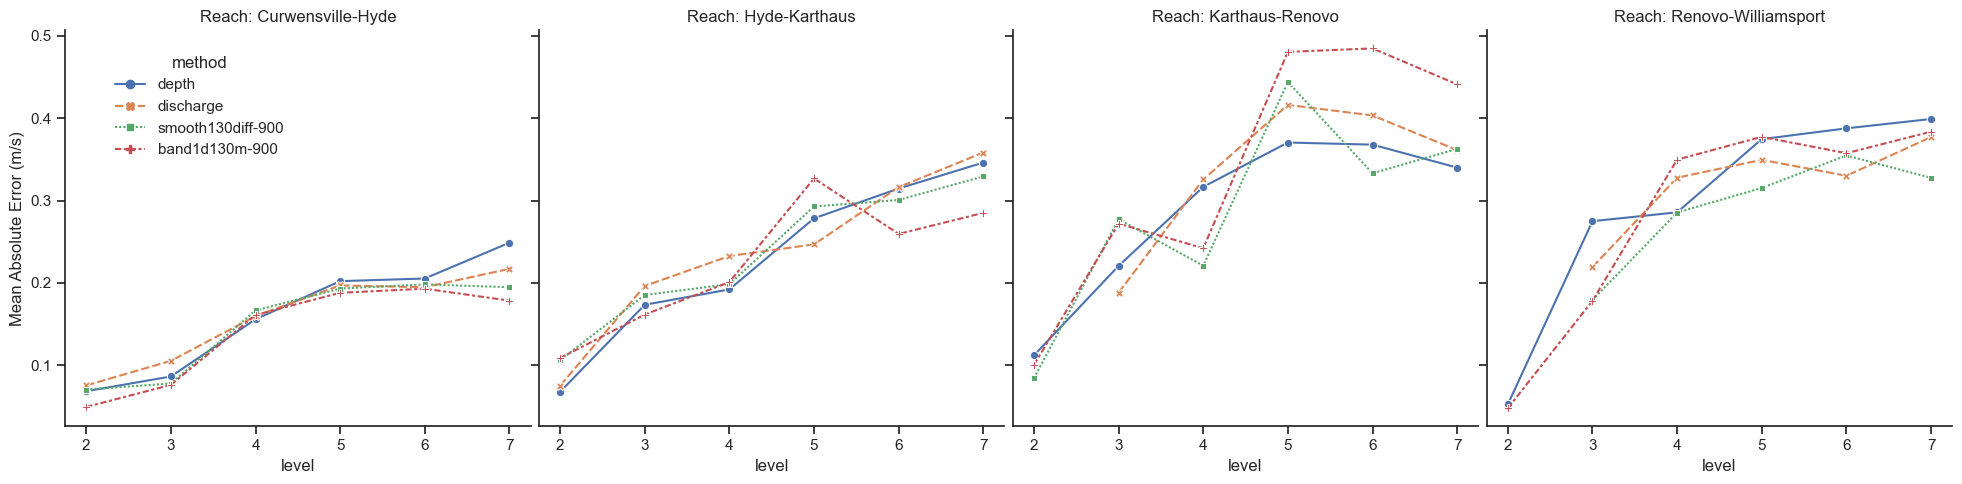

In [26]:
my.markdown(f"## Old Figure 6 Using Least Squares")

sns.set_theme(style="ticks")

# Create a table for results
plot_df = pd.DataFrame()

no_mask = pd.Series(True, index=xcorr.index) # Keep everything
plausible_mask = xcorr['plausible_c'] # Filter out implausible values

def regress_vc(group):
    #print(group.name)
    method, level, reach = group.name
    if len(group) < 4:
        return pd.Series([np.nan, np.nan, np.nan, np.nan, len(group)], index=[f'robust_slope', f'robust_mae', f'linear_slope', f'linear_mae', f'count'])

    clean_group = group.dropna()
    y = clean_group['avg_val_c']
    x = clean_group['celerity']
    robust = sm.RLM(y, x).fit()
    robust_test = np.mean(np.abs(y - robust.fittedvalues))
    robust_mae = np.mean(np.abs(robust.resid))
    lsq = linregress(x,y)
    lsq_fit = (lsq.slope * x) + lsq.intercept
    resid = y - lsq_fit
    lsq_mae = np.mean(np.abs(resid))
    
    
    return pd.Series([robust.params.iloc[0], robust_mae, lsq.slope, lsq_mae, x.count()], index=[f'robust_slope', f'robust_mae', 'lsq_slope', 'lsq_mae', f'count'])

view_methods = ['depth', 'discharge', 'smooth130diff-900', 'band1d130m-900']

grouped = (xcorr.loc[plausible_mask]
            .loc[(view_methods),['avg_val_c', 'celerity']]
            .groupby(['method', 'level', 'reach'], sort=False)
          )
plot_df = grouped.apply(regress_vc).unstack()

#print(my.big_df(robust_mae))

grid = sns.relplot(
    data=plot_df, 
    x='level', 
    y='lsq_mae', 
    hue='method', 
    style='method', 
    col='reach', 
    kind='line', 
    markers=True)
(grid.set_ylabels("Mean Absolute Error (m/s)")
     .set_titles("Reach: {col_name}")
     .tight_layout(w_pad=0)
     #.refline(y=1, color="0.4")
)
sns.move_legend(grid, "upper left", bbox_to_anchor=(.05, .9), frameon=False)

filename = path / f"Old_Figure_6_LSQ.{filetype}"
#print(f"Saving figure to {filename}")
#grid.savefig(filename, dpi=dpi, bbox_inches='tight')